In [1]:
import os
import cv2
import torch
from IPython.display import Video
from IPython.display import display, HTML
from keras.preprocessing.image import load_img
from transformers import BlipProcessor, BlipForConditionalGeneration,BartForConditionalGeneration, BartTokenizer
import numpy as np

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load BLIP model For Caption Generation


In [2]:
# # Initialize BLIP model for visual description
# print("Loading BLIP model...")
# processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
# print("Loaded Successfully...")

In [3]:
# # Save the processor and model locally
# save_directory = "./Models/blip_model"

# # Save model
# model.save_pretrained(save_directory)

# # Save processor
# processor.save_pretrained(save_directory)

# print(f"Model and processor saved in directory: {save_directory}")

In [4]:
# Load the saved model and processor
save_directory = "./Models/blip_model"
processor = BlipProcessor.from_pretrained(save_directory)
model = BlipForConditionalGeneration.from_pretrained(save_directory)

print("Model and processor loaded successfully!")

Model and processor loaded successfully!


Load Bart Model For Summarization

In [5]:
# # Initialize BART model for summarization
# print("Loading BART summarization model...")
# bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
# bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
# print("Loaded Successfully... !!")

In [6]:
# # Save the processor and model locally
# save_directory = "./Models/bart_model"

# # Save the model
# bart_model.save_pretrained(save_directory)

# # Save the tokenizer
# bart_tokenizer.save_pretrained(save_directory)

# print(f"Model and tokenizer saved in directory: {save_directory}")

In [7]:
# Load the saved model and processor
save_directory = "./Models/bart_model"
bart_tokenizer = BartTokenizer.from_pretrained(save_directory)
bart_model = BartForConditionalGeneration.from_pretrained(save_directory)

print("Model and processor loaded successfully!")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bart\configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Model and processor loaded successfully!


Function To Load a Video

In [8]:
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    # Check if video is opened correctly
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    # Get the video's FPS (frames per second) and total frame count
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_duration = total_frames / fps
    print(f"Video loaded successfully. FPS: {fps}, Total Frames: {total_frames}, Duration: {video_duration:.2f} seconds.")

    return cap,fps,total_frames,video_duration


Function to load Frames of a Video

In [9]:
def load_frame(cap,fps):
    # Extract 1 frame per second from the video
    frame_list = []
    frame_count = 0

    print("Extracting 1 frame per second from the video...")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("End of video or error reading frame.")
            break

        # Extract 1 frame per second (using FPS to calculate frame intervals)
        if frame_count % int(fps) == 0:
            frame_list.append(frame)

        frame_count += 1

    cap.release()
    print(f"Extracted {len(frame_list)} frames from the video.")
    return frame_list,frame_count

In [10]:

# Use GPU if available, otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using device: {device}")


Using device: cpu


Function to generate caption from an image

In [11]:
# Function to generate caption from an image
def generate_caption(image):
    inputs = processor(images=image, return_tensors="pt").to(device)
    out = model.generate(**inputs, max_new_tokens=50)  # Increase max_new_tokens if you want longer descriptions
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

Function to generate caption for each frame and merging them to generate description

In [12]:
# Generate descriptions for all frames and combine them
def generate_description(frame_list):
    final_description = ""

    print("Generating descriptions for each frame...")
    for i, frame in enumerate(frame_list):
        description = generate_caption(frame)
        print(f"Frame {i+1} Description: {description}")
        final_description += f"{description}. "
        
    print("\n - - - - - * End Of Frames * - - - - - ")    
    return final_description

Function to generate summary of Description

In [13]:
def summarize_text(text):
    inputs = bart_tokenizer(text, return_tensors="pt", max_length=1024, truncation=True, padding=True).to(device)
    summary_ids = bart_model.generate(
        inputs['input_ids'],
        max_length=150,
        min_length=60,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

Function to Verify User Entered caption for video

In [14]:
import spacy
# from sentence_transformers import SentenceTransformer, util

# Load SpaCy model
nlp = spacy.load("en_core_web_lg")
# nlp=spacy.load("en_core_web_md")

In [15]:
def are_similar_spacy(word1, word2, threshold=0.6):
    # Convert words to Spacy tokens and compute similarity
    token1 = nlp(word1)
    token2 = nlp(word2)
    similarity = token1.similarity(token2)
    # print(similarity)
    return similarity >= threshold  # Return True if similarity is above threshold

def match_word(word,summary):
    word=word.lower()
    for word2 in summary:
        word2=word2.lower()
        if(word.lower()==word2.lower()):
            return True
        if(are_similar_spacy(word,word2)==True):
            return True
    return False


def match_caption(usrcap,summ):

    wordusrcap = usrcap.split()
    summaryword=summ.split()
    
    match_count=0
    notfound=[]
    if(len(wordusrcap)<=1):
        print("Enter the Caption Again")
        return notfound
    for word in wordusrcap:
        flag=match_word(word,summaryword)
        if(flag==True):
            match_count=match_count+1
        if(flag==False):
            notfound.append(word)

    print("Similarity : ", (match_count*100)/len(wordusrcap))
    # print(notfound)
    return notfound




In [16]:
usrcap=""
wordusrcap = usrcap.split()
print(wordusrcap)

[]


# Generating Caption for Images

In [18]:
img_path=r"..\SportsVideoClassification\Demo\IMAGES\Image21.jpeg"
img = load_img((img_path), target_size=(224,224,3))
capt=generate_caption(img)
print(capt)

a group of young boys playing soccer on a field


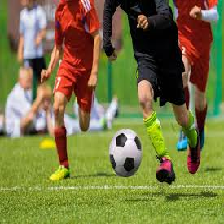

In [ ]:
img

In [19]:
display(HTML(f"<div style='font-size:30px;font-weight:700; word-wrap: break-word;'>{capt}</div>"))

# Generating Captions and Summary of a Video

In [ ]:
video_path = r"..\SportsVideoClassification\Demo\VIDEOS\TestVideo21.mp4"

cap,fps,total_frames,video_duration=load_video(video_path)
frame_list,frame_count=load_frame(cap,fps)
final_description=generate_description(frame_list)

Video loaded successfully. FPS: 30.0, Total Frames: 530, Duration: 17.67 seconds.
Extracting 1 frame per second from the video...
End of video or error reading frame.
Extracted 18 frames from the video.
Generating descriptions for each frame...
Frame 1 Description: a soccer game is shown in the middle of a stadium
Frame 2 Description: a soccer game is shown in the middle of a stadium
Frame 3 Description: a soccer game is shown in a large stadium
Frame 4 Description: a soccer game is shown in the middle of a stadium
Frame 5 Description: a soccer game is shown in the middle of a stadium
Frame 6 Description: a soccer game is shown in the middle of a stadium
Frame 7 Description: a soccer game is shown in the middle of a stadium
Frame 8 Description: a soccer game is shown in the middle of a stadium


In [ ]:


# Display the string in a div with a specified width
display(HTML(f"<div style='width: 1250px; word-wrap: break-word;'>{final_description}</div>"))

In [ ]:
summary=summarize_text(final_description)

Summary of The Given Video 

In [ ]:
display(HTML(f"<div style='width: 1100px;font-size:30px;font-weight:700;word-wrap: break-word;'>{summary}</div>"))

In [ ]:
Video(video_path, embed=True, width=400, height=400)


# Caption Verification

In [ ]:
usrcap="  A man is playing Soccer in the stadium"

In [ ]:
notfound=match_caption(usrcap,summary)
print("Unmatched : ",notfound)

Similarity :  87.5
Unmatched :  ['man']
